In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle as pkl

In [2]:
data = pd.read_excel('./data/DatArticle_orig.xls', header=0)
data=data.drop(0)
data=data[['Temperature.1', 'mumax.1' , 'qp.1']]
X=data[['Temperature.1', 'mumax.1']]
y=data['qp.1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(17, 9)


,Time,Glucose,Biomass,Protein,Acetate,Vreal,Temperature,Induction,Batch
1,0,8.53,0.237527,0,0.061,1.500919,36.975,0,0.0
2,0.833333,7.95,0.758194,0,0.132,1.478419,36.99,0,0.0
3,1.616667,6.76,1.282143,0,0.171,1.456207,37.005,0,0.0
4,3.383333,0.365,4.88775,0,0.227,1.461191,37.11,0,0.0
5,4.116667,0.011,6.175,0,0.281,1.483981,36.705,0,1.0
6,5.733333,0,12.871429,0,0,1.55967,36.855,0,1.0
7,6.533333,0,16.071429,0,0,1.622434,37.32,0,1.0
8,7.4,0.01,19.55,0,0,1.713444,37.11,0,1.0
9,8.0,0,23.071429,0,0,1.779788,36.93,0,1.0
10,9.283333,0,23.982143,0.13101,0,1.738042,27.99,1,1.0


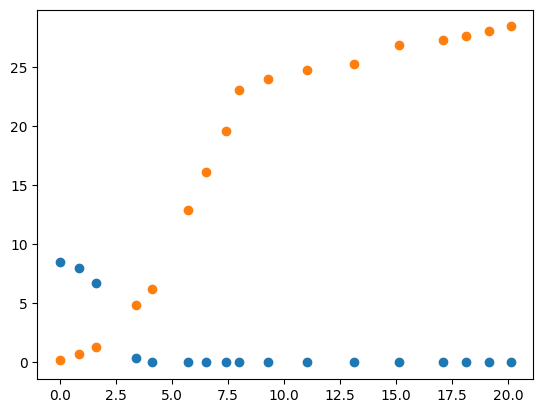

In [26]:
df = pd.read_excel('./data/BR02_for_model.xlsx', header=0)
df.drop(0, inplace=True)
t_start = df.iloc[0,0]
t_end = df.iloc[-1,0]
t_span = [t_start, t_end]
print(df.shape)
display(df)
# plt.plot(df['Time'], df['Protein'], 'o')
plt.plot(df['Time'], df['Glucose'], 'o')
plt.plot(df['Time'], df['Biomass'], 'o')

In [ ]:
import os, sys, pickle
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint
import sklearn
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

FLIERPROPS = {
    'markerfacecolor':'black', 
    'markersize':1, 
    'markeredgecolor':'black'
}

INTERP_T = list()

def main():

    if len(sys.argv) != 4:
        print("Usage: python simulate.py <experiment_file> <model_file> <result_dir>")
        sys.exit(1)

    experiment_file = sys.argv[1]
    model_file = sys.argv[2]
    result_dir = sys.argv[3]

    if not os.path.exists(result_dir):
        os.mkdir(result_dir)

    log_fh = open(result_dir + '/userJourney_online.log', 'w', encoding='utf-8')

    # print('\n', file=sys.stdout)
    print('\n', file=log_fh)

    # print('1. Initiating %s with cmd arguments:\n\tExperimental data: %s\n\tSVR model file: %s\n\tResult dir%s' % (sys.argv[0], sys.argv[1], sys.argv[2], sys.argv[3]), file=sys.stdout)
    print('1. Initiating %s with cmd arguments:\n\tExperimental data: %s\n\tSVR model file: %s\n\tResult dir%s' % (sys.argv[0], sys.argv[1], sys.argv[2], sys.argv[3]), file=log_fh)

    # print('2. Loading experimental data for validating post simulation results', file=sys.stdout)
    print('2. Loading experimental data for validating post simulation results', file=log_fh)
    A3 = pd.read_excel(experiment_file, header=0)

    # print('3. Loading SVR model', file=sys.stdout)
    print('3. Loading SVR model', file=log_fh)
    svm_regressor = pickle.load(open(model_file, 'rb'))

    # print('4. Starting the experiment. Establishing the connection with the bioreactor...', file=sys.stdout)
    print('4. Starting the experiment. Establishing the connection with the bioreactor...', file=log_fh)
    #Define parameters from excel file
    #k=pd.read_excel('ParametresPo_monod.xls')
    k=[0.6794 ,0.002, 0.2572 ,0.2605, 0.07715, 0.02471]
    
    #drop units row
    A3=A3.drop(0)
    to3 = A3.iloc[0, 0]
    tf3 = A3.iloc[-1, 0]
    tspan3 = [to3, tf3]

    Gluc3 = A3.iloc[0, 1]
    Bio3 = A3.iloc[0, 2]
    Ace3 = A3.iloc[0, 4]
    V3 = A3.iloc[0, 5]
    Pro3 = A3.iloc[0, 3]
    x03 = [Bio3, Gluc3, Ace3, Pro3, V3]
    Ext3 = A3[['Time', 'Temperature', 'Induction']].values.astype('float64')
    #Solve simple model and hybrid model for the protein production
    t3 = np.linspace(to3, tf3, num=100)
    # print(t3)
    # print(len(t3))
    #result_simple=odeint(Model_Nano1_Temp1, x03, t3, args=(k, Ext3))
    result_hybride=odeint(Model_Nano1_Hybride, x03, t3, args=(k, Ext3, svm_regressor))
    # print(INTERP_T)
    # print(len(INTERP_T))
    # print(Ext3)
    # print(result_hybride)
    # print(len(result_hybride))
    for t3_idx in range(len(t3)):

        time_point = t3[t3_idx]
        biomass = result_hybride[t3_idx][0]
        glucose = result_hybride[t3_idx][1]
        # acetate = result_hybride[t3_idx][2]
        protein = result_hybride[t3_idx][3]

        if t3_idx == 0:
            # print('\tTemperature received: %f (Celcius) | Predicted concentrations - biomass: %f (g/L), glucose: %f (g/L), protein: %f (g/L)' % (INTERP_T[t3_idx], biomass, glucose, protein), file=sys.stdout)
            print('\tTemperature received: %f (Celcius) | Predicted concentrations - biomass: %f (g/L), glucose: %f (g/L), protein: %f (g/L)' % (INTERP_T[t3_idx], biomass, glucose, protein), file=log_fh)
        elif t3_idx == 55:
            # print('\tINDUCTION INITIATED! Temperature received: %f (Celcius) | Predicted concentrations - biomass: %f (g/L), glucose: %f (g/L), protein: %f (g/L)' % (INTERP_T[t3_idx*24], biomass, glucose, protein), file=sys.stdout)
            print('\tINDUCTION INITIATED! Temperature received: %f (Celcius) | Predicted concentrations - biomass: %f (g/L), glucose: %f (g/L), protein: %f (g/L)' % (INTERP_T[t3_idx*24], biomass, glucose, protein), file=log_fh)
        else:
            # print('\tTemperature received: %f (Celcius) | Predicted concentrations - biomass: %f (g/L), glucose: %f (g/L), protein: %f (g/L)' % (INTERP_T[t3_idx*24], biomass, glucose, protein), file=sys.stdout)
            print('\tTemperature received: %f (Celcius) | Predicted concentrations - biomass: %f (g/L), glucose: %f (g/L), protein: %f (g/L)' % (INTERP_T[t3_idx*24], biomass, glucose, protein), file=log_fh)

    # print('5. Ending the experiment. Closing connection with the bioreactor...', file=sys.stdout)
    print('5. Ending the experiment. Closing connection with the bioreactor...', file=log_fh)

    # print('6. Evaluating simulation results based on experimental data', file=sys.stdout)
    print('6. Evaluating simulation results based on experimental data', file=log_fh)

    fig, ax = plt.subplots(figsize=(12,8))
    plt.scatter(A3['Time'].values,A3['Protein'].values, label='experimental')
    plt.plot(t3,result_hybride[:,3], label='simulated')
    plt.axvline(x = 10.5, color = 'red', label = 'induction', ls='--')
    plt.xlabel('time(m)', fontsize = 10)
    plt.ylabel('c(g/L)', fontsize = 10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Simulated vs experimentally measured protein concentration', fontsize = 10)
    plt.legend(loc='best', fontsize = 8, title='Protein concentration', title_fontsize = 10, fancybox=True, facecolor='lightgrey')
    plt.tight_layout()
    plt.savefig(result_dir + '/lineplot.protein_concentration.pdf', dpi=300, format='pdf')
    plt.close(fig)

    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(t3,result_hybride[:,0],label='biomass')
    plt.plot(t3,result_hybride[:,1],label='glucose')
    # plt.plot(t3,result_hybride[:,2],label='acetate')
    plt.axvline(x = 10.5, color = 'red', label = 'induction', ls='--')
    plt.xlabel('time(h)', fontsize = 10)
    plt.ylabel('c(g/L)', fontsize = 10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Simulated biomass and glucose', fontsize = 10)
    plt.legend(loc='best', fontsize = 8, title='Simulation', title_fontsize = 10, fancybox=True, facecolor='lightgrey')
    plt.tight_layout()
    plt.savefig(result_dir + '/lineplot.biomass_glucose.pdf', dpi=300, format='pdf')
    plt.close(fig)

    # print('\n', file=sys.stdout)
    print('\n', file=log_fh)
    log_fh.close()

def Model_Nano1_Hybride(X, t, k, exter, svm_regressor):
    #svm training
    #print("Mean Squared Error:", mse)
    # Parameters
    mumax, Ks, Ysx, Ysp, YsAc, YxAc = k
    a=0.0142
    b=0.3383
    # Variables
    X = np.maximum(X, 0)
    X1, S, Ac, P, V = X

    # Externals
    T = np.interp(t, exter[:, 0], exter[:, 1])
    INTERP_T.append(T)

    # Flow of Glucose solution
    if len(exter[:, 0]) == 15:
        if t <= 4.9:
            Fs = 0
        elif 4.9 < t <= 9.2:
            Fs = 0.011 * t + 0.0015
        elif t > 9.2:
            Fs = 0.0006 * t + 0.0015
            mumax = a * T + b
    elif len(exter[:,0]) == 17:
        if t <= 5.1:
            Fs = 0
        elif 5.1 < t <= 8.6:
            Fs = 0.013 * t + 0.0015
        else:
            Fs = 0.0001 * t + 0.0015
            mumax = a * T + b
    
    elif len(exter[:, 0]) == 21 and exter[0, -1] < 14.92:
        if t <= 6.5:
            Fs = 0
        elif 6.5 < t <= 9.9:
            Fs = 0.006 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.00005 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 21 and exter[0, -1] > 14.92:
        if t <= 7:
            Fs = 0
        elif 7 < t <= 9.9:
            Fs = 0.006 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.00005 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 21 and exter[0, -1] < 14.92:
        if t <= 6.5:
            Fs = 0
        elif 6.5 < t <= 9.9:
            Fs = 0.006 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.00005 * t + 0.0015  # induction Qcte
            mumax = a * T + b      
    elif len(exter[:, 0]) == 28:
        if t <= 5.55:
            Fs = 0
        elif 5.55 < t <= 9:
            Fs = 0.013 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0003 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 27:
        if t <= 5.5:
            Fs = 0
        elif 5.5 < t <= 11.8:
            Fs = 0.01 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0002 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    elif len(exter[:, 0]) == 25:
        if t <= 5.7:
            Fs = 0
        elif 5.7 < t <= 10:
            Fs = 0.01 * t + 0.0015  # fed-batch with µset=0.38h-1
        else:
            Fs = 0.0002 * t + 0.0015  # induction Qcte
            mumax = a * T + b
    # Add more conditions for different lengths of exter data if needed

    Sin = 1.43 * 200
    Fsample = 30

    # Constants
    Tref = 37

    # Kinetics
    mu = mumax * S / (Ks + S)

    # State variables

    dVdt = Fs

    rX = mu * X1
    dXdt = rX - dVdt / V * X1

    alpha = 3.35
    gama1 = 0.57
    gama2 = 2.52
    Ap1 = 34.55
    Ap2 = 30.67
    beta = 0.76

    ind = np.interp(t, exter[:, 0], exter[:, 2])
    if ind == 0:
        rP = 0
    elif ind > 0:
        # Implement the model for rP when ind is positive
        # INTERP_T.append(T)
        T_norm =(T-28)/(37-28)
        mu_norm = (mu-0)/(0.073675586-0)
        d=[[T_norm, mu_norm]]
        rP_norm = svm(svm_regressor,d)
        rP_norm=rP_norm[0]
        rP=rP_norm*(0.0408-0)+0

    dPdt = rP*X1 - dVdt / V * P
    rAc = mu * X1
    rS = rX / Ysx - YxAc * X1
    dAcdt = rAc - dVdt / V * Ac
    dSdt = Fs * Sin - S * dVdt / V - rS

    dX = [dXdt, dSdt, dAcdt, dPdt, dVdt]
    return dX

def svm(svm_regressor,X):
    y=svm_regressor.predict(X)
    return y

if __name__ == '__main__':
    main()